In [1]:
#@title Import necessary packages and set correct device

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage import io
from skimage.measure import regionprops
from skimage.segmentation import slic
from skimage.util import img_as_float
from torch.utils.data import random_split
from torchvision.ops import box_iou
from tqdm import tqdm

from modules.refcocog import RefCOCOg, RefCOCOgSample
from modules.yoloclip import display_preds

if torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA GPU
    print("[INFO] GPU found, using GPU.")
else:
    device = torch.device("cpu")
    print("[INFO] No GPU found, using CPU instead.")


[INFO] GPU found, using GPU.


In [2]:
#@title Import RefCOCOg dataset and its train/val/test splits

# modify
dataset_path = "/media/dmmp/vid+backup/Data/refcocog"

dataset = RefCOCOg(ds_path=dataset_path)

train_ds = RefCOCOg(ds_path=dataset_path, split='train')
val_ds = RefCOCOg(ds_path=dataset_path, split='val')
test_ds = RefCOCOg(ds_path=dataset_path, split='test')

# keep only a toy portion of each split
keep = 0.1
train_ds, _ = random_split(train_ds, [int(keep * len(train_ds)), len(train_ds) - int(keep * len(train_ds))])
val_ds, _ = random_split(val_ds, [int(keep * len(val_ds)), len(val_ds) - int(keep * len(val_ds))])
test_ds, _ = random_split(test_ds, [int(keep * len(test_ds)), len(test_ds) - int(keep * len(test_ds))])

print(f"Train size: {len(train_ds)}")
print(f"Val size:   {len(val_ds)}")
print(f"Test size:  {len(test_ds)}")


Train size: 4222
Val size:   257
Test size:  502


In [3]:
#@title Utility function to downsample a map

def downsample_map(map, factor):
    # number of blocks in each dimension
    blocks_h = map.shape[0] // factor
    blocks_w = map.shape[1] // factor

    # reshape the original matrix into blocks
    blocks = map[:blocks_h * factor, :blocks_w * factor].reshape(blocks_h, factor, blocks_w, factor)

    # calculate the average of each block
    averages = blocks.mean(axis=(1, 3))

    return averages


In [4]:
#@ Utility functions to perform best bounding box search

def quality_f(matrix):
    ths = matrix.min()

    if matrix[matrix > ths].size == 0:
        return 0

    lit_area = np.sum(matrix > ths) / matrix.size
    area_score = matrix[matrix > ths].sum()

    return lit_area * area_score


def find_best_box(heatmap):
    # Normalize the heatmap
    # heatmap = heatmap / np.max(heatmap)

    # Initialize the best score and best box
    best_score = float('-inf')
    best_box = None

    rects = list()

    # Loop over all possible box sizes and positions
    for w in range(1, heatmap.shape[1] + 1):
        for h in range(1, heatmap.shape[0] + 1):
            for i in range(heatmap.shape[1] - w + 1):
                for j in range(heatmap.shape[0] - h + 1):

                    # Get current sub-region
                    candidate = heatmap[j:j + h, i:i + w]

                    # Compute the score for this box
                    score = quality_f(candidate)

                    # Update the best score and best box if necessary
                    if score > best_score:
                        best_score = score
                        # best_box = (i, j, w, h)
                        best_box = (i, j, w, h)

    return best_box


In [5]:
#@ Definition of SLIC + CLIP visual grounding pipeline

class ClipSlic:

    def __init__(self, masks=(4, 16, 64), q=0.95, d=16, device="cpu", quiet=False):
        self.device = device
        self.clip_model, self.clip_prep = clip.load("ViT-L/14", device=device)
        self.quiet = quiet
        self.masks = masks
        self.q = q
        self.d = d

    def __call__(self, img_sample, prompt, show=True, show_pipeline=True):

        if self.quiet:
            show = False
            show_pipeline = False

        np_image = img_as_float(io.imread(img_sample.path))

        if show_pipeline:
            fig, ax = plt.subplots(1, 4, figsize=(20, 5))

            ax[0].imshow(np_image)
            ax[0].axis("off")

        hmaps = list()

        for i, superpixels in enumerate(self.masks):

            segments = slic(np_image, n_segments=superpixels, sigma=5)
            regions = regionprops(segments)

            prompt_tkn = clip.tokenize(prompt).to(device)

            with torch.no_grad():
                prompt_enc = self.clip_model.encode_text(prompt_tkn)

            images_encs = list()

            pbar = tqdm(regions, position=0, leave=False) if not self.quiet else regions

            for region in pbar:

                if not self.quiet:
                    pbar.set_description(f"[INFO] Mask {i + 1}/{len(self.masks)} | computing CLIP scores", refresh=True)

                rect = region.bbox
                rect = (rect[1], rect[0], rect[3], rect[2])

                sub_image = sample.img.crop(rect)
                sub_image = self.clip_prep(sub_image).unsqueeze(0)
                sub_image = sub_image.to(device)

                with torch.no_grad():
                    image_enc = self.clip_model.encode_image(sub_image)

                images_encs.append(image_enc)

            images_encs = torch.cat(images_encs, dim=0)

            scores = prompt_enc @ images_encs.T

            scores = scores.squeeze().numpy()

            heatmap = np.zeros((segments.shape[0], segments.shape[1]))

            for i in range(segments.shape[0]):
                for j in range(segments.shape[1]):
                    heatmap[i, j] = scores[segments[i, j] - 1]

            hmaps.append(heatmap)

        p_heatmap = np.mean(np.array(hmaps), axis=0)

        if show_pipeline:
            ax[1].imshow(p_heatmap)
            ax[1].axis("off")

        # Shut down pixels below a certain threshold
        ths = np.quantile(p_heatmap.flatten(), self.q)
        fp_heatmap = p_heatmap.copy()
        fp_heatmap[p_heatmap < ths] = ths

        if show_pipeline:
            ax[2].imshow(fp_heatmap)
            ax[2].axis("off")

        # Downsample the heatmap by a factor d
        dfp_heatmap = downsample_map(fp_heatmap, self.d)

        if show_pipeline:
            ax[3].imshow(dfp_heatmap)
            ax[3].axis("off")

        pred_bbox = find_best_box(dfp_heatmap)

        pred_bbox = [pred_bbox[0] * self.d + self.d // 2,
                     pred_bbox[1] * self.d + self.d // 2,
                     pred_bbox[2] * self.d - self.d // 2,
                     pred_bbox[3] * self.d - self.d // 2]

        pred_bbox = [pred_bbox[0], pred_bbox[1], pred_bbox[2] + pred_bbox[0], pred_bbox[3] + pred_bbox[1]]

        gt_bbox = img_sample.bbox

        if show:
            display_preds(sample.img, prompt, pred_bbox, sample.bbox, "SLIC + CLIP")

        iou = box_iou(
            torch.tensor([pred_bbox]),
            torch.tensor([gt_bbox])
        )

        return iou


100%|███████████████████████████████████████| 890M/890M [12:41<00:00, 1.22MiB/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

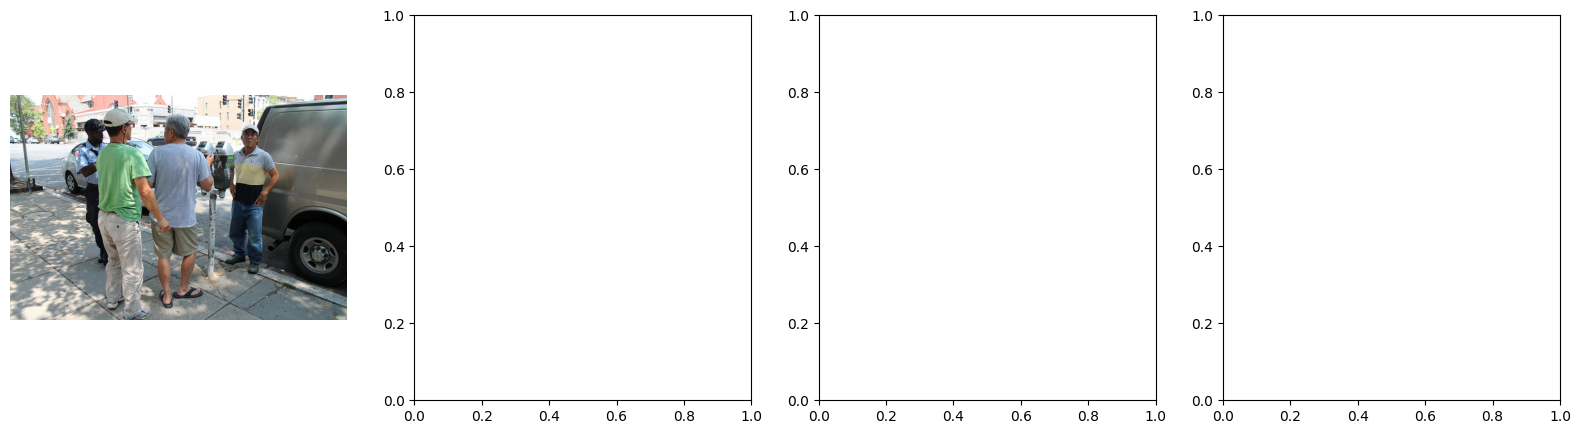

In [6]:
%matplotlib inline

idx = 7095  #np.random.randint(0, len(dataset))

sample = RefCOCOgSample(**dataset[idx])

clipslic = ClipSlic(device=device, q=0.9)

score = clipslic(sample, sample.sentences[0])


In [25]:
#@title Function definition to test visual grounding with a given pipeline

def visual_grounding_test(vg_pipeline, dataset):
    scores = list()

    for sample in tqdm(dataset, desc=f"Testing on {len(dataset)} images"):

        sample = RefCOCOgSample(**sample)

        for sentence in sample.sentences:

            try:
                sc = vg_pipeline(sample, sentence, show=False)
            except ValueError:
                continue

            scores.append(sc)

    for metric in scores[0].keys():
        avg_metric = np.mean([score[metric] for score in scores])

        print("Avg. {}: {:.3f}".format(metric, avg_metric))


In [ ]:
#@title Test ClipSlic on the test set

clipslic = ClipSlic(device=device, quiet=True, q=0.9)

visual_grounding_test(clipslic, test_ds)
